In [1]:
%matplotlib inline
from pandas_datareader import data
import pandas as pd
from SALib.sample import latin
from functions.stylizedfacts import *
from functions.evolutionaryalgo import *
from functions.helpers import hurst, organise_data
import matplotlib.pyplot as plt
import quandl

# Evolutionary algorithm to calibrate model

## 1 get data from S&P500

In [2]:
start_date = '1960-01-01'
end_date = '2016-8-31'
window = 320

spy_real_price = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_real_price = spy_real_price.rename(columns={"Value": "price"})

spy_returns = spy_real_price.pct_change()[1:]

spy_dividends = quandl.get("MULTPL/SP500_DIV_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_dividends = spy_dividends.rename(columns={"Value": "dividends"})
spy_dividends.index = spy_dividends.index + pd.offsets.MonthBegin(1)
spy_all = spy_dividends.join(spy_real_price)

spy_t_bill = quandl.get("FRED/INTGSTUSM193N", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
spy_t_bill = spy_t_bill.rename(columns={"Value": "dividends"})

spy_all['t_bill_int'] = spy_t_bill / 100

spy_all['div_growth'] = spy_all['dividends'].pct_change()
spy_all['av_div_growth'] = spy_all['div_growth'].rolling(window=window,center=False).mean()
spy_all['yield'] = spy_all['dividends'].iloc[1:] / spy_all['price'].iloc[:-1]
spy_all['ml_discount'] = [0.052 for x in range(len(spy_all))]
spy_all['fixed_yield'] = spy_all['t_bill_int'] + spy_all['ml_discount']

spy_all = spy_all.iloc[-window:-1]

spy_all['fundamental'] = ((1 + spy_all['av_div_growth']) / (spy_all['fixed_yield'] - spy_all['av_div_growth'])) * spy_all['dividends']
spy_all['dev_fundamental'] = spy_all['price'] - spy_all['fundamental']

## 2 Extract stylized facts

In [3]:
spy_autocorrelation = autocorrelation_returns(spy_returns['price'], 25)
spy_kurtosis = kurtosis(spy_returns['price'])
spy_autocorrelation_abs = autocorrelation_abs_returns(spy_returns['price'], 25)
spy_hurst = hurst(spy_all['price'])

spy_dev_fund_hurst = hurst(spy_all['dev_fundamental'].iloc[:-1])
stylized_facts_spy = [spy_autocorrelation, spy_kurtosis, spy_autocorrelation_abs, spy_hurst, spy_dev_fund_hurst]

stylized_facts_spy = pd.DataFrame(stylized_facts_spy, columns=['S&P500'], 
             index=['autocorrelation', 'kurtosis', 'autocorrelation_abs', 'hurst', 'hurst_dev_from_fund']).to_dict()['S&P500']

In [4]:
stylized_facts_spy

{'autocorrelation': 0.00030320061625216735,
 'autocorrelation_abs': 0.049914003700974562,
 'hurst': 0.41423988932290962,
 'hurst_dev_from_fund': 0.40316509821294022,
 'kurtosis': 3.0676490833426238}

## 3 Define parameter space bounds 

Table 1 shows the parameter bounds, free parameters are **bold**. 

| Parameter | Values (start, stop, step) |
| -------------| ------------|
| **n_traders**       | 100, 5000, 25      |
| ticks       | 2500, 2500, 0   |
| **trader_sample_size**       | 1, 100, 10      |
| fundamental_value       | 100, 100, 0      |
| **std_fundamental**       | 0.01, 0.2 , 0.01     |
| **std_noise**       | 0.01, 0.35, 0.01      |
| **std_vol**       | 1, 50, 1      |
| **max_order_expiration_ticks**       | 5, 200, 5       |
| **w_fundamentalists**       | 0.0, 100.0., 1.0      |
| **w_momentum**       | 0.0, 100.0, 1.0      |
| **w_random**       | 0.0, 100.0, 1.0      |
| **w_mean_reversion**       | 0.0, 100.0, 1.0       |
| w_buy_hold       | 0.0, 0.0, 0.0      |
| **spread_max**       | 0.01, 0.15, 0.01       |
| **horizon_min**       | 1, 8, 1      |
| **horizon_max**       | 9, 30, 1      |
*Table 1 Parameter bounds*

In [5]:
# parameter_space = {'n_traders':[100, 5000], 'trader_sample_size':[1, 100], 'std_fundamental':[0.01, 0.2], 
#                    'std_noise':[0.01, 0.35], 'std_vol':[1, 50], 
#                    'max_order_expiration_ticks':[5, 200], 'w_fundamentalists':[0.0, 100.0], 'w_momentum':[0.0, 100.0],
#                    'w_random':[0.0, 100.0], 'w_mean_reversion':[0.0, 100.0], 
#                    'spread_max':[0.01, 0.15], 'horizon_min':[1, 8], 
#                    'horizon_max':[9, 30]}

In [45]:
problem = {
  'num_vars': 13,
  'names': ['n_traders', 'trader_sample_size', 'std_fundamental', 'std_noise', 
            'std_vol', 'max_order_expiration_ticks', 'w_fundamentalists', 'w_momentum',
           'w_random', 'w_mean_reversion', 'spread_max',
           'horizon_min', 'horizon_max'],
  'bounds': [[1000, 2000], [1, 30], [0.01, 0.12], [0.05, 0.30], 
             [1, 15], [10, 100], [0.0, 100.0], [0.0, 100.0], 
             [0.0, 100.0], [0.0, 100.0], [0.01, 0.15],
             [1, 8], [9, 30]]
}

## 4 Sample the parameter space using a latin hypercube

In [46]:
population_size = 10

In [47]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()

In [49]:
# transform some of the parameters to integer
for idx, parameters in enumerate(latin_hyper_cube):
    # ints: 0, 1, 4, 5, 11, 12
    latin_hyper_cube[idx][0] = int(latin_hyper_cube[idx][0])
    latin_hyper_cube[idx][1] = int(latin_hyper_cube[idx][1])
    latin_hyper_cube[idx][4] = int(latin_hyper_cube[idx][4])
    latin_hyper_cube[idx][5] = int(latin_hyper_cube[idx][5])
    latin_hyper_cube[idx][11] = int(latin_hyper_cube[idx][11])
    latin_hyper_cube[idx][12] = int(latin_hyper_cube[idx][12])

## 5 Run evolutionary algorithm

In [50]:
# create initial population
population = []
for parameters in latin_hyper_cube:
    pars = {}
    for key, value in zip(problem['names'], parameters):
        pars[key] = value
    population.append(Individual(pars, [], np.inf))
all_populations = [population]
av_pop_fitness = []

In [51]:
fixed_parameters = {"ticks": 500, "fundamental_value": 100, "w_buy_hold": 0.0}
iterations = 15
NRUNS = 1

In [52]:
for generation in range(iterations):
    # simulate every population
    simulated_population, fitness = simulate_population(all_populations[generation], NRUNS, fixed_parameters, stylized_facts_spy)
    # record population fitness
    av_pop_fitness.append(fitness)
    print('generation: ', generation, 'fitness: ', fitness)
    # add a new, evolved population to the list of populations
    all_populations.append(evolve_population(simulated_population, fittest_to_retain=0.3, random_to_retain=0.2, 
                                             parents_to_mutate=0.3, parameters_to_mutate=0.1, problem=problem))

generation:  0 fitness:  4136.82637517
generation:  1 fitness:  2837.85323642
generation:  2 fitness:  2501.29921719
generation:  3 fitness:  4899.19831685
generation:  4 fitness:  1963.69512267
generation:  5 fitness:  134.925480011
generation:  6 fitness:  443.457200997
generation:  7 fitness:  268.055217074
generation:  8 fitness:  7.37347600707
generation:  9 fitness:  7.37347600707
generation:  10 fitness:  7.37347600707
generation:  11 fitness:  7.37347600707
generation:  12 fitness:  7.37347600707
generation:  13 fitness:  7.37347600707
generation:  14 fitness:  7.37347600707
generation:  15 fitness:  7.37347600707
generation:  16 fitness:  7.37347600707
generation:  17 fitness:  7.37347600707
generation:  18 fitness:  7.37347600707
generation:  19 fitness:  7.37347600707


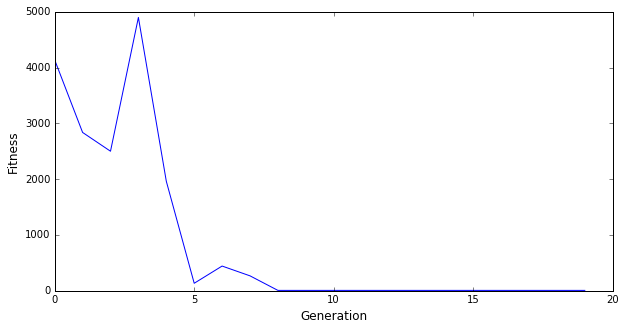

In [53]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(av_pop_fitness)), av_pop_fitness)
ax1.set_ylabel('Fitness', fontsize='12')
ax1.set_xlabel('Generation', fontsize='12')

## Extract parameter values:

### Best parameters

In [54]:
all_populations[-1][0].parameters

{'horizon_max': 15,
 'horizon_min': 6,
 'max_order_expiration_ticks': 92,
 'n_traders': 1413,
 'spread_max': 0.040136915087013045,
 'std_fundamental': 0.10872321803799265,
 'std_noise': 0.20508407891045205,
 'std_vol': 1,
 'trader_sample_size': 26,
 'w_fundamentalists': 76.66646857709344,
 'w_mean_reversion': 65.01917050983388,
 'w_momentum': 47.53421946123167,
 'w_random': 1.4948772502086316}

### Best stylized facts compared to actual stylized facts

In [55]:
print('simulation:')
print(all_populations[-1][0].stylized_facts)
print('s&p500:')
print(stylized_facts_spy)

simulation:
{'autocorrelation': 0.00058222186504637596, 'autocorrelation_abs': 0.022017699983722574, 'hurst_dev_from_fund': 0.27540621743254767, 'kurtosis': 8.1143137822193889, 'hurst': 0.42403790366880117}
s&p500:
{'autocorrelation': 0.00030320061625216735, 'autocorrelation_abs': 0.049914003700974562, 'hurst_dev_from_fund': 0.40316509821294022, 'kurtosis': 3.0676490833426238, 'hurst': 0.41423988932290962}
